In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font='DejaVu Sans')

np.set_printoptions(suppress=True)

## Import EDI metadata

In [2]:
edi19 = pd.read_csv('data/DATA_INVENTORY_2019_0308.csv')
edi18 = pd.read_csv('../fy18-annual-report/data/dataset_inventory_2018_03_11.csv')
edi18['OPENDATA_PORTAL'] = edi18.OPENDATA_PORTAL == 'Yes'

print('Number of 2018 enterprise datasets: {0}'.format(edi18.shape[0]))
print('Number of 2019 enterprise datasets: {0}'.format(edi19.shape[0]))

Number of 2018 enterprise datasets: 1640
Number of 2019 enterprise datasets: 1779


## Import and prep participant data

In [3]:
## Importing data
participants = pd.read_csv('../fy18-annual-report/data/agency_participants_archived.csv')

## Standardizing acronyms to match to last year's EDI agency list
def fix_acronyms(x):
    if x.AGENCY_ACRONYM == 'PCSB':
        return 'DCPCSB'
    elif x.AGENCY_ACRONYM == 'CFA':
        return 'CAH'
    elif x.AGENCY_ACRONYM == 'DCPCS':
        return 'DCPCSB'
    elif x.AGENCY_ACRONYM == 'BOEE':
        return 'BOE'
    elif x.AGENCY_ACRONYM == 'ORCA':
        return 'MORCA'
    elif x.AGENCY_ACRONYM == 'BOEE':
        return 'BOE'
    elif x.AGENCY_ACRONYM == 'SIA':
        return 'DCSIC'
    elif x.AGENCY_NAME == 'Commission on Fathers, Men and Boys':
        return 'CFMB'
    elif x.AGENCY_NAME == 'Corrections Information Council':
        return 'CIC'
    elif x.AGENCY_NAME == 'Office of Labor Relations and Collective Bargaining':
        return 'OLRCB'
    elif x.AGENCY_NAME == 'Commission For The Arts and Humanities':
        return 'CAH'
    elif x.AGENCY_NAME == 'Real Property Tax Appeals Commission':
        return 'RPTAC'
    else:
        return x.AGENCY_ACRONYM
    
participants['AGENCY_ACRONYM'] = participants.apply(lambda x: fix_acronyms(x), axis = 1)

## Standardize column names

In [4]:
COLUMN_RENAMES = {
    'EDI_ID': 'DATAINVENTORYID',
    'ACRONYM': 'AGENCYCODE',
    'APPLICATIONNAME':  'LINKEDAPPLICATIONNAME', 
    'DATASETCATEGORYNAME': 'DATASETCATEGORY',
    'DATASETTYPENAME': 'DATASETTYPE',
    'UPDATEINTERVALNAME': 'UPDATEINTERVAL',
    'PUBLICINTERESTNAME': 'PUBLICINTRESTINDATAVALUE'
}

edi19.rename(columns = COLUMN_RENAMES, inplace = True)

In [5]:
COLUMN_RENAMES = {
    'RECORD_ID': 'DATAINVENTORYID',
    'AGENCY_NAME': 'AGENCYNAME',
    'AGENCY_ACRONYM': 'AGENCYCODE',
    'DATASET_NAME': 'DATASETNAME',
    'DATA_OWNER': 'DATAOWNER',
    'DATASET_CLASSIFICATION_NAME': 'DATASETCLASSIFICATIONNAME',
    'DATASET_CATEGORY': 'DATASETCATEGORY',
    'DATASET_TYPE': 'DATASETTYPE',
    'UPDATE_INTERVAL': 'UPDATEINTERVAL',
    'INTEREST': 'PUBLICINTRESTINDATAVALUE',
    'ISDESIGNEEAPPRCLASSIFICATION': 'ISDESIGNEEAPPRDCLASSIFICATION'
}
edi18.rename(columns = COLUMN_RENAMES, inplace = True)

## Combine 2018 and 2019 EDI

In [6]:
edi19['EDI_CYCLE'] = 2019
edi18['EDI_CYCLE'] = 2018

cols19 = ['DATAINVENTORYID', 'AGENCYNAME', 'AGENCYCODE', 'DATASETNAME', 'DATAOWNER', 'DATASETCATEGORY', 'DATASETTYPE', 'DATASETCLASSIFICATIONNAME', 'EDI_CYCLE', 'OPENDATA_PORTAL']
cols18 = ['DATAINVENTORYID', 'AGENCYNAME', 'AGENCYCODE', 'DATASETNAME', 'DATAOWNER', 'DATASETCATEGORY', 'DATASETTYPE', 'DATASETCLASSIFICATIONNAME', 'EDI_CYCLE', 'OPENDATA_PORTAL']

df = pd.concat((edi19[cols19], edi18[cols18]), sort = True, axis = 0)

## Properly assign datasets to agencies

In [7]:
## Some agencies entered datasets that are owned or produced by entities outside the DC government
## These datasets are properly attributed to the agencies that use them as enterprise datasets

not_dc  = ['AOC', 'BID', 'CT', 'GSA', 'MWCOG', 'NCPC', 'NGA', 'NPS', 'USDA', 'USDOT', 'USFWS', 'USGS', 'USPS', 'WDCEP', 'WMATA']

def fix_agencies(x):
    if x.AGENCYCODE == 'CENSUS':
        return 'OP'
    elif x.AGENCYCODE == 'FEMA':
        return 'DOEE'
    if x.AGENCYCODE == 'OA':
        return 'DCOA'
    elif x.AGENCYCODE == 'CFA':
        return 'CAH'
    elif x.AGENCYCODE == 'DCPCS':
        return 'DCPCSB'
    elif x.AGENCYCODE in not_dc:
        return 'OCTO'
    else:
        return x.AGENCYCODE
df['AGENCYCODE'] = df.apply(lambda x: fix_agencies(x), axis = 1)

### Assigning OCTO Data to Data Owners

In [8]:
def data_owner(x):
    if (x.AGENCYCODE == 'OCTO') and ('PASS' in x.DATAOWNER):
        return 'OCP'
    else:
        return x.AGENCYCODE
    
df['AGENCYCODE'] = df.apply(lambda x: data_owner(x), axis = 1)

In [9]:
def fix_agency_code(x):
    if (x.AGENCYCODE=='DC Water'):
        return 'DCWATER'
    else:
        return x.AGENCYCODE

df['AGENCYCODE'] = df.apply(lambda x: fix_agency_code(x), axis = 1)

## How many agencies recorded enterprise datasets?

In [10]:
print('Number of agencies recording datasets in 2019: {0}'.format(len(df[(df.EDI_CYCLE == 2019)].AGENCYCODE.unique())))
print('Number of agencies recording datasets in 2018: {0}'.format(len(df[df.EDI_CYCLE == 2018].AGENCYCODE.unique())))
print('Number of datasets recorded in 2019: {0}'.format(len(df[df.EDI_CYCLE == 2019])))
print('Number of datasets recorded in 2018: {0}'.format(len(df[df.EDI_CYCLE == 2018])))

Number of agencies recording datasets in 2019: 75
Number of agencies recording datasets in 2018: 73
Number of datasets recorded in 2019: 1779
Number of datasets recorded in 2018: 1640


In [11]:
p19 = participants.merge(pd.DataFrame(df[df.EDI_CYCLE == 2019].groupby('AGENCYCODE').size()).reset_index(), how = 'outer', left_on = 'AGENCY_ACRONYM', right_on = 'AGENCYCODE')
p18 = participants.merge(pd.DataFrame(df[df.EDI_CYCLE == 2018].groupby(['AGENCYCODE']).size()).reset_index(), how = 'outer', left_on = 'AGENCY_ACRONYM', right_on = 'AGENCYCODE')

p19['participated'], p19['EDI_CYCLE'] = p19.AGENCYCODE.notnull(), 2019
p18['participated'], p18['EDI_CYCLE'] = p18.AGENCYCODE.notnull(), 2018

cols = ['AGENCY_ACRONYM', 'TYPE_OF_AGENCY', 'EDI_CYCLE', 'PARTICIPATING', 'participated']
p = pd.concat((p19[cols], p18[cols]), axis = 0)

   EDI_CYCLE      TYPE_OF_AGENCY  participated  counts
0       2018      Mayoral Agency         False       6
1       2018      Mayoral Agency          True      63
2       2018  Non-Mayoral Agency         False      20
3       2018  Non-Mayoral Agency          True      10
4       2019      Mayoral Agency         False       5
5       2019      Mayoral Agency          True      64
6       2019  Non-Mayoral Agency         False      19
7       2019  Non-Mayoral Agency          True      11


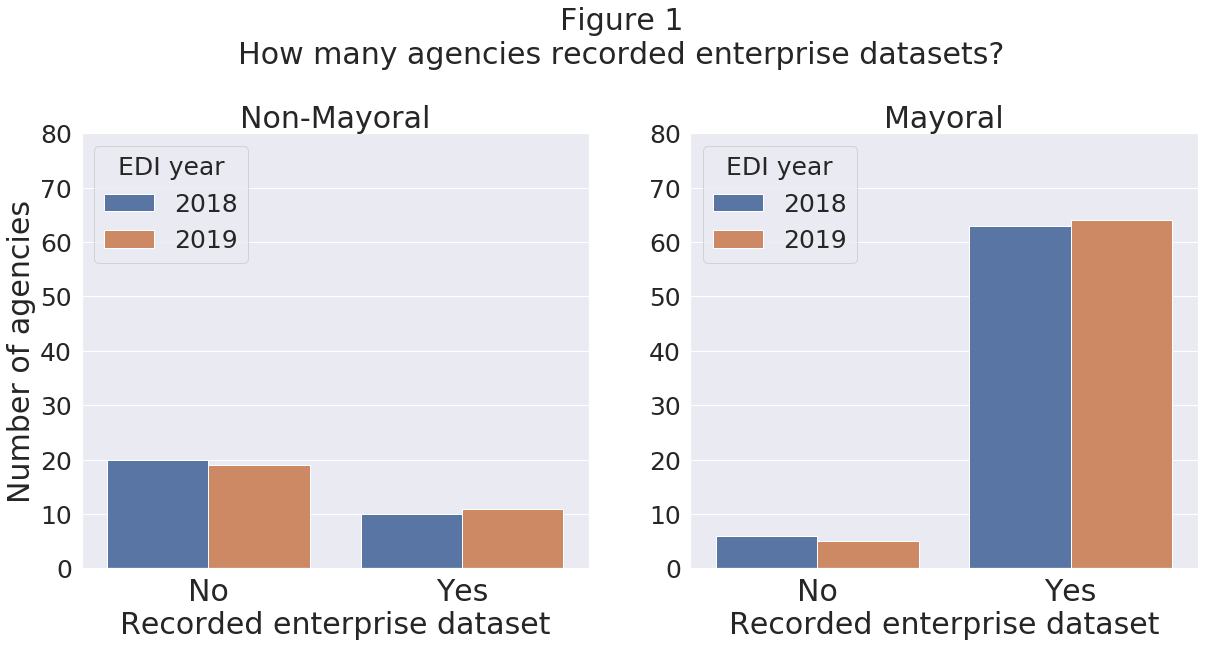

In [12]:
fsize = 30
lfsize = 25

paggs = pd.DataFrame(p.groupby(['EDI_CYCLE', 'TYPE_OF_AGENCY', 'participated']).size()).reset_index().rename(columns = {0: 'counts'})
print(paggs)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))
mayoral = paggs[paggs.TYPE_OF_AGENCY == 'Mayoral Agency']
nonmayoral = paggs[paggs.TYPE_OF_AGENCY == 'Non-Mayoral Agency']
sns.barplot(x = nonmayoral.participated, y = nonmayoral.counts, hue = nonmayoral.EDI_CYCLE, ci = None, ax = ax1)
sns.barplot(x = mayoral.participated, y = mayoral.counts, hue = mayoral.EDI_CYCLE, ci = None, ax = ax2)
ax1.set_ylim(0,80)
ax2.set_ylim(0,80)
plt.suptitle('Figure 1\nHow many agencies recorded enterprise datasets?', fontsize = fsize, y = 1.1)
ax1.set_title('Non-Mayoral', fontsize = fsize)
ax2.set_title('Mayoral', fontsize = fsize)
ax1.set_xlabel('Recorded enterprise dataset', fontsize = fsize)
ax2.set_xlabel('Recorded enterprise dataset', fontsize = fsize)
ax1.set_ylabel('Number of agencies', fontsize = fsize)
ax2.set_ylabel('', fontsize = fsize)
ax1.set_xticklabels(['No', 'Yes'], fontsize = fsize)
ax2.set_xticklabels(['No', 'Yes'], fontsize = fsize)
ax1.set_yticklabels(np.arange(0,90,10), fontsize = lfsize)
ax2.set_yticklabels(np.arange(0,90,10), fontsize = lfsize)
leg1 = ax1.legend(title = 'EDI year', fontsize = lfsize, loc = 2)
leg2 = ax2.legend(title = 'EDI year', fontsize = lfsize)
leg1.set_title('EDI year', prop = {'size': lfsize})
leg2.set_title('EDI year', prop = {'size': lfsize})

## How many enterprise datasets did agencies record?

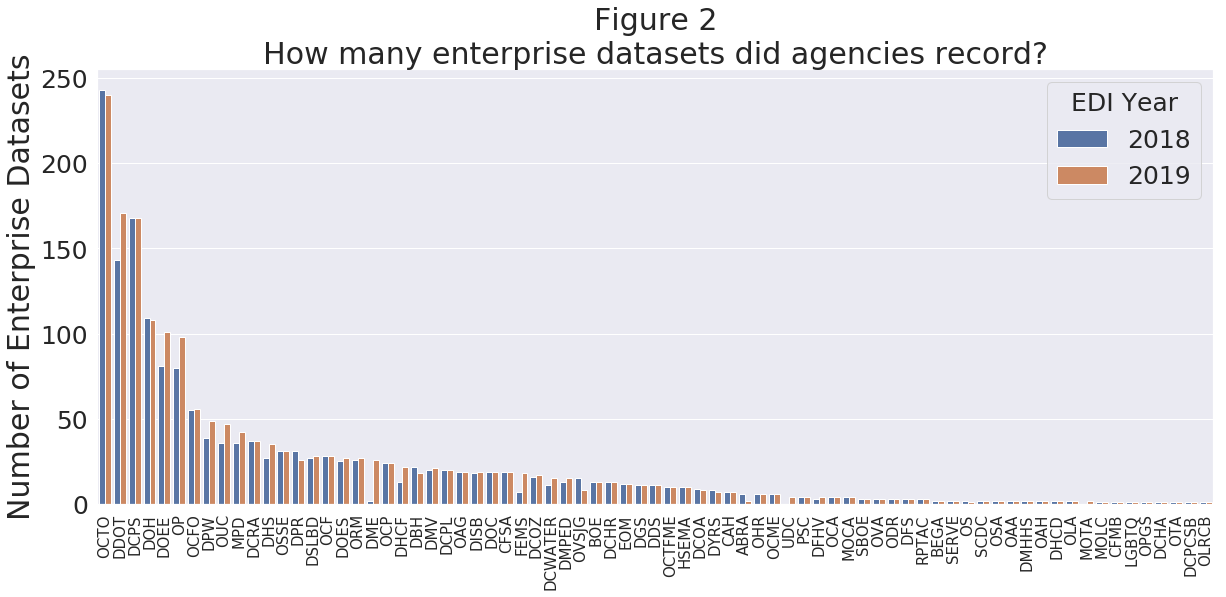

In [13]:
fsize = 30
lfsize = 25

agency_aggs = pd.DataFrame(df.groupby(['AGENCYCODE', 'EDI_CYCLE']).size().sort_values(ascending = False)).reset_index().rename(columns = {0: 'counts'})
fig, ax = plt.subplots(1,1, figsize = (20, 8))
sns.barplot(agency_aggs.AGENCYCODE, agency_aggs.counts, hue = agency_aggs.EDI_CYCLE)
plt.xticks(rotation=90)
ax.set_title('Figure 2\nHow many enterprise datasets did agencies record?', fontsize = fsize)
ax.tick_params(axis = 'y', which = 'major', labelsize=lfsize)
ax.tick_params(axis = 'x', which = 'major', labelsize=15)
leg = ax.legend(title = 'EDI Year', fontsize = lfsize, loc = 1)
leg.set_title('EDI Year', prop = {'size': lfsize})
ax.set_xlabel('', fontsize = fsize)
ax.set_ylabel('Number of Enterprise Datasets', fontsize = fsize)

### Compare the number of datasets agencies recorded in 2019 to 2018

In [14]:
compare_cycles = agency_aggs[agency_aggs.EDI_CYCLE == 2019].merge(agency_aggs[agency_aggs.EDI_CYCLE == 2018], how = 'left', on = 'AGENCYCODE', suffixes = ['_2019', '_2018'])
compare_cycles['difference'] = compare_cycles.counts_2019 - compare_cycles.counts_2018
compare_cycles.sort_values('difference', ascending = False).head(n = 10)

,AGENCYCODE,EDI_CYCLE_2019,counts_2019,EDI_CYCLE_2018,counts_2018,difference
1,DDOT,2019,171,2018.0,143.0,28.0
18,DME,2019,26,2018.0,2.0,24.0
4,DOEE,2019,101,2018.0,81.0,20.0
5,OP,2019,98,2018.0,80.0,18.0
27,FEMS,2019,18,2018.0,7.0,11.0
8,OUC,2019,47,2018.0,36.0,11.0
7,DPW,2019,49,2018.0,39.0,10.0
20,DHCF,2019,22,2018.0,13.0,9.0
11,DHS,2019,35,2018.0,27.0,8.0
9,MPD,2019,42,2018.0,36.0,6.0


## How did agencies classify enterprise datasets?

  class_name  EDI_CYCLE  counts
0    Level 0       2018     708
1    Level 0       2019     794
2    Level 1       2018     137
3    Level 1       2019     151
4    Level 2       2018     193
5    Level 2       2019     183
6    Level 3       2018     508
7    Level 3       2019     564
8    Level 4       2018      94
9    Level 4       2019      87


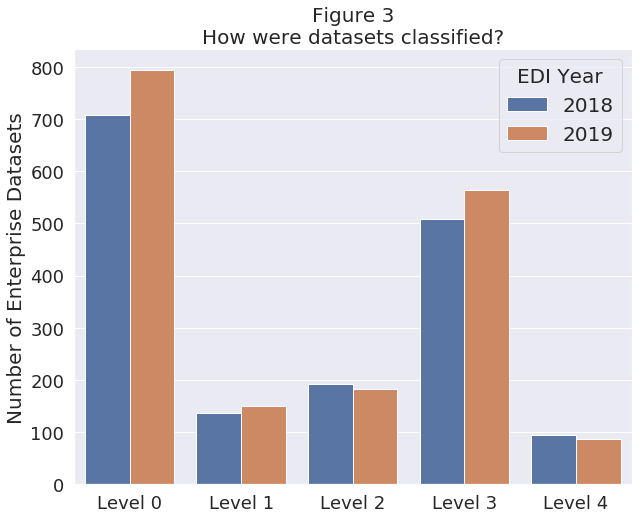

In [15]:
class_names = {
    'Level 0': 'Level 0',
    'Level 1': 'Level 1',
    'Level 2': 'Level 2',
    'Level 3': 'Level 3',
    'Level 4': 'Level 4',
    'Open': 'Level 0',
    'Public Not Proactively Released': 'Level 1',
    'For District Government Use': 'Level 2',
    'Confidential': 'Level 3',
    'Restricted Confidential': 'Level 4'
}
df['class_name'] = df.DATASETCLASSIFICATIONNAME.map(class_names)
class_df = pd.DataFrame(df.groupby(['class_name', 'EDI_CYCLE']).size()).reset_index().rename(columns = {0: 'counts'})
print(class_df)

fig, ax = plt.subplots(1,1, figsize = (10,8))
sns.barplot(class_df.class_name, class_df.counts, hue = class_df.EDI_CYCLE)
ax.set_title('Figure 3\nHow were datasets classified?', fontsize = 20)
ax.tick_params(axis = 'y', which = 'major', labelsize=18)
ax.tick_params(axis = 'x', which = 'major', labelsize=18)
leg = ax.legend(title = 'EDI Year', fontsize = 20, loc = 1)
leg.set_title('EDI Year', prop = {'size': 20})
ax.set_xlabel('', fontsize = 20)
ax.set_ylabel('Number of Enterprise Datasets', fontsize = 20)

### Compare dataset classifications in 2019 to 2018

In [16]:
classes = class_df[class_df.EDI_CYCLE == 2019].merge(class_df[class_df.EDI_CYCLE == 2018], how = 'left', on = 'class_name', suffixes = ['_2019', '_2018'])
classes['diff'] = classes.counts_2019 - classes.counts_2018
classes.sort_values('diff', ascending = False)

,class_name,EDI_CYCLE_2019,counts_2019,EDI_CYCLE_2018,counts_2018,diff
0,Level 0,2019,794,2018,708,86
3,Level 3,2019,564,2018,508,56
1,Level 1,2019,151,2018,137,14
4,Level 4,2019,87,2018,94,-7
2,Level 2,2019,183,2018,193,-10


## How many Level 0 datasets are on the Open Data Portal?

   open_data_portal  EDI_CYCLE  counts
0             False       2018     191
1             False       2019     217
2              True       2018     517
3              True       2019     577


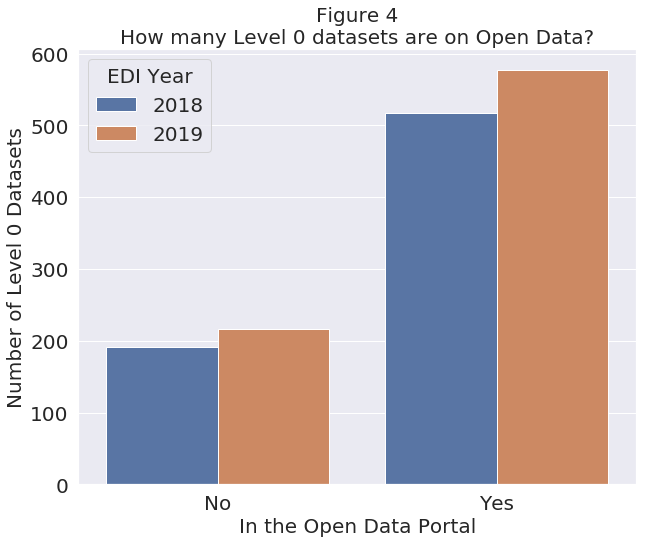

In [17]:
df['open_data_portal'] = df.OPENDATA_PORTAL 
open_data = df[(df.DATASETCLASSIFICATIONNAME == 'Level 0') | (df.DATASETCLASSIFICATIONNAME == 'Open')].copy()
open_aggs = pd.DataFrame(open_data.groupby(['open_data_portal', 'EDI_CYCLE']).size()).reset_index().rename(columns = {0: 'counts'})
print(open_aggs)

fig, ax = plt.subplots(1,1, figsize = (10,8))
sns.barplot(open_aggs.open_data_portal, open_aggs.counts, open_aggs.EDI_CYCLE, ax = ax)
ax.set_title('Figure 4\nHow many Level 0 datasets are on Open Data?', fontsize = 20)
ax.set_xlabel('In the Open Data Portal', fontsize = 20)
ax.set_ylabel('Number of Level 0 Datasets', fontsize = 20)
ax.set_xticklabels(['No', 'Yes'], fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
leg = ax.legend(title = 'EDI Year', fontsize = 20, loc = 2)
leg.set_title('EDI Year', prop = {'size': 20})

## How did agencies categorize enterprise datasets?

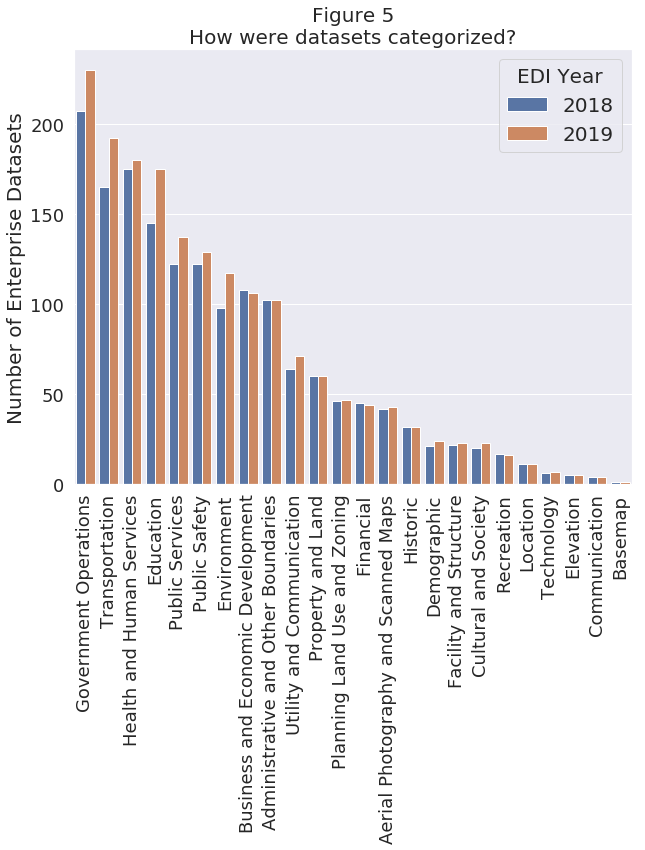

In [18]:
def fix_categories(x):
    if x.DATASETCATEGORY == 'Health':
        return 'Health and Human Services'
    elif x.DATASETCATEGORY == 'Society':
        return 'Cultural and Society'
    else:
        return x.DATASETCATEGORY
df['DATASETCATEGORY'] = df.apply(lambda x: fix_categories(x), axis = 1)

cat_aggs = pd.DataFrame(df.groupby(['DATASETCATEGORY', 'EDI_CYCLE']).size().sort_values(ascending = False)).reset_index().rename(columns = {0: 'counts'})

fig, ax = plt.subplots(1,1,figsize = (10,8))
sns.barplot(cat_aggs.DATASETCATEGORY, cat_aggs.counts, cat_aggs.EDI_CYCLE, ax = ax)
ax.set_title('Figure 5\nHow were datasets categorized?', fontsize = 20)
ax.tick_params(axis = 'x', which = 'major', labelsize=18, rotation = 90)
ax.tick_params(axis = 'y', which = 'major', labelsize=18)
leg = ax.legend(title = 'EDI Year', fontsize = 20, loc = 1)
leg.set_title('EDI Year', prop = {'size': 20})
ax.set_xlabel('', fontsize = 20)
ax.set_ylabel('Number of Enterprise Datasets', fontsize = 20)

In [19]:
compare = cat_aggs[cat_aggs.EDI_CYCLE == 2019].merge(cat_aggs[cat_aggs.EDI_CYCLE == 2018], how = 'left', on = 'DATASETCATEGORY', suffixes = ['_2019', '_2018'])
compare['diff'] = compare.counts_2019 - compare.counts_2018
compare.sort_values('diff', ascending = False)

,DATASETCATEGORY,EDI_CYCLE_2019,counts_2019,EDI_CYCLE_2018,counts_2018,diff
3,Education,2019,175,2018,145,30
1,Transportation,2019,192,2018,165,27
0,Government Operations,2019,230,2018,207,23
6,Environment,2019,117,2018,98,19
4,Public Services,2019,137,2018,122,15
5,Public Safety,2019,129,2018,122,7
9,Utility and Communication,2019,71,2018,64,7
2,Health and Human Services,2019,180,2018,175,5
15,Demographic,2019,24,2018,21,3
17,Cultural and Society,2019,23,2018,20,3


## Retired dataset analysis

In [20]:
retired = pd.read_csv('data/retired_2018_03_09.csv')
retired.columns = retired.columns.str.upper()
print('Number of datasets retired in 2019: {0}'.format(retired.shape[0]))

Number of datasets retired in 2019: 16


  ACRONYM  counts
0    ABRA       4
1     DHS       2
2   DMPED       1
3     OUC       9


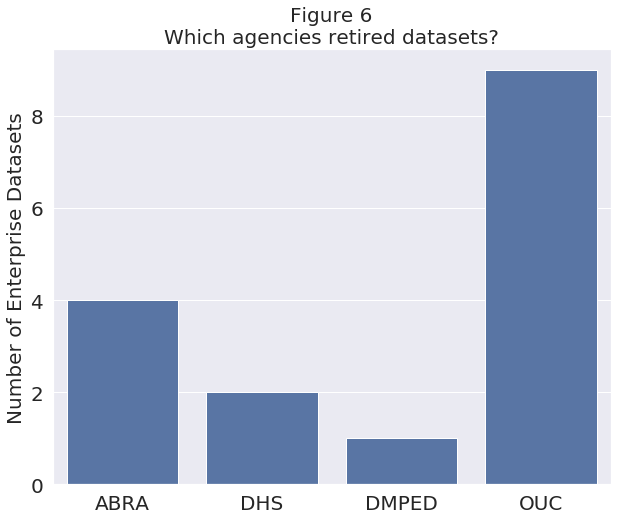

In [21]:
raggs = pd.DataFrame(retired.groupby('ACRONYM').size().sort_index()).reset_index().rename(columns = {0: 'counts'})
print(raggs)

fig, ax = plt.subplots(1,1, figsize = (10,8))
sns.barplot(raggs['ACRONYM'], raggs.counts, color = sns.color_palette()[0], ax = ax)
ax.set_title('Figure 6\nWhich agencies retired datasets?', fontsize = 20)
ax.tick_params(axis = 'both', which = 'major', labelsize=20)
ax.set_xlabel('', fontsize = 20)
ax.set_ylabel('Number of Enterprise Datasets', fontsize = 20)

  DATASETCLASSIFICATIONNAME  counts
0                   Level 0       5
0                   Level 1       0
1                   Level 2       6
2                   Level 3       3
3                   Level 4       2


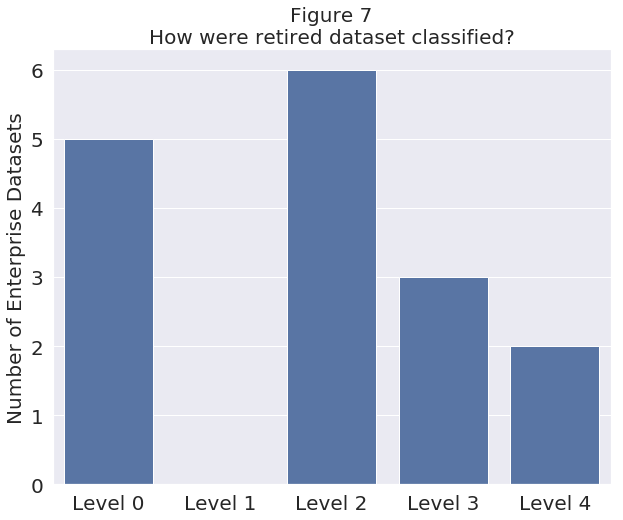

In [22]:
raggs = pd.DataFrame(retired.groupby('DATASETCLASSIFICATIONNAME').size().sort_index()).reset_index().rename(columns = {0: 'counts'})

level_1 = pd.DataFrame([['Level 1', 0]], columns = ['DATASETCLASSIFICATIONNAME', 'counts'])
raggs = raggs.append(level_1).sort_values('DATASETCLASSIFICATIONNAME')
print(raggs)

fig, ax = plt.subplots(1,1, figsize = (10,8))
sns.barplot(raggs['DATASETCLASSIFICATIONNAME'], raggs.counts, color = sns.color_palette()[0], ax = ax)
ax.set_title('Figure 7\nHow were retired dataset classified?', fontsize = 20)
ax.tick_params(axis = 'both', which = 'major', labelsize=20)
ax.set_xlabel('', fontsize = 20)
ax.set_ylabel('Number of Enterprise Datasets', fontsize = 20)

In [23]:
retired.OPENDATA_PORTAL.value_counts()

False    15
True      1
Name: OPENDATA_PORTAL, dtype: int64